<center><h1>ECSE 443: Introduction to Numerical Analysis in Electrical Engineering</center></h1>
<center><h3>Assignment 2: Advanced Model Fitting</center></h3>
<center><h3>Due: Monday, March 9th, 2020<sup>th</sup>, 2020 at 11:59pm EST on [myCourses](https://mycourses2.mcgill.ca/)</center></h3>
<center><h3>Final weight: __15%__</center></h3>
    
    
$\newcommand{\norm}[1]{\left\| #1 \right\|}$
$\newcommand{\normsq}[1]{\norm{#1}^2}$
$\newcommand{\bstheta}{\boldsymbol{\theta}}$
$\newcommand{\bsalpha}{\boldsymbol{\alpha}}$
$\newcommand{\bsmu}{\boldsymbol{\mu}}$
$\newcommand{\bssigma}{\boldsymbol{\sigma}}$
$\newcommand{\bsSigma}{\boldsymbol{\Sigma}}$
$\newcommand{\bfA}{\mathbf{A}}$
$\newcommand{\bfa}{\mathbf{a}}$
$\newcommand{\bfb}{\mathbf{b}}$
$\newcommand{\bfe}{\mathbf{e}}$
$\newcommand{\bfr}{\mathbf{r}}$
$\newcommand{\bfv}{\mathbf{v}}$
$\newcommand{\bfx}{\mathbf{x}}$
$\newcommand{\bfX}{\mathbf{X}}$
$\newcommand{\bfy}{\mathbf{y}}$
$\newcommand{\gaussian}{\mathcal{N}}$
$\newcommand{\cond}{\operatorname{cond}}$
$\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$
$\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}$
$\newcommand{\pder}[1]{\frac{\partial}{\partial #1}}$

<u style="font-size:16pt;">Assignment submission process</u>

Download and modify the `ipynb` notebook we provide on myCourses and submit your modified file, renamed according to your student ID, as

<center><font color='red'>`[YourStudentID]`.ipynb</font></center>

For example, if your id is **234567890**, your submission filename should be **234567890.ipynb**.


<div class="alert alert-warning" role="alert">
     Note that every time you submit a new file, your previous submission will be overwritten.  <b>All submissions must be made using myCourses</b>. You can submit as many times as you like, but we will only grade the last submission.
</div>

<u style="font-size:16pt;">Late policy & Python `import` statements</u>

This assignment is to be completed individually. 

<div class="alert alert-danger" role="alert">
     You will lose <b>5% per hour</b>. past the deadline, up to a maximum of -100%. 
</div>

We provide all import statements required to complete the assignment.

<div class="alert alert-danger" role="alert">
    You must not use any <code>import</code>s other than the ones we provide.
    Doing so will result in a score of <b>zero (0%)</b> on the assignment.
</div>

# Polynomial regression with MLE and MAP [40%]

You will implement a *maximum likelihood estimator* (MLE) and *maximum a posteriori* (MAP) estimator. You will test both on a *polynomial regression* problem. 

![Comparing an overdetermined degree-7 polynomial fit using linear least squares (LLS), MLE and MAP.](./poly_reg.png) 

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell in the Jupyter Notebook to include the required modules for this task.
</div>

In [1]:
%matplotlib inline

from numpy import array, poly1d, polyval, linspace, zeros, sum, sort, absolute
from numpy.random import uniform,normal, seed
from numpy.linalg import cond, norm, solve, lstsq
import matplotlib.pyplot as plt

## Polynomial regression

The overdetermined degree-$m$ polynomial regression problem -- with an explicit corruption/noise model on the data -- seeks an interpolant across $n$ data samples $(x_i, y_i)$ that satisfies:
$$
y_i = \sum_{j=0}^{m}\theta_j x_i^j + \epsilon_i  \quad (i = 1, \ldots, n)
$$
where:
* $x_i$ is the *independent coordinate* of sample $i$, with $\bfx = \{x_0 \ldots x_{n-1} \}$,
* $y_i$ is the *dependent coordinate* of sample $i$, with $\bfy = \{y_0 \ldots y_{n-1} \}$,
* $\epsilon_i \sim \mathcal{N}(\mu, \sigma^2)$ is standard *Gaussian noise* corrupting the output $y_i$, and
* $\bstheta = \{\theta_0, \theta_1 ,\dots, \theta_{m}\}$ are the $p=m+1$ polynomial coefficients we are solving for.

Note that one common way of rewriting this model is by "folding in" the deterministic component into the mean of the stochastic component, as:

$$
y_i \sim \mathcal{N}\left(\mu+ \sum_{j=0}^{m}\theta_j x_i^j, \sigma^2\right)~.
$$

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell to generate noisy polynomial data to test your estimator on
</div>

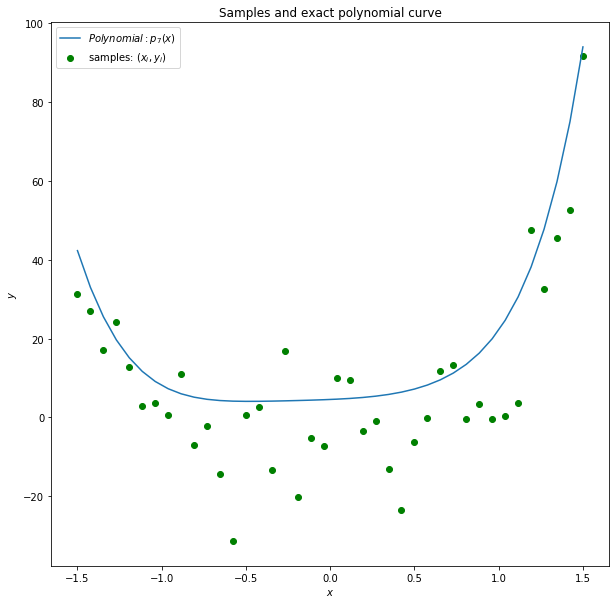

In [7]:
seed(0)

n = 40 # Number of samples
m = 7  # Degree of the polynomial
p = m+1  # Number of parameters (degree of the polynomial plus 1)

# Generate a random, degree-m polynomial:
# sample the polynomial parameters from a Gaussian
alpha = 1. # Mean of the polynomial parameters
beta = 2.  # Standard deviation of the polynomial parameters
theta = normal(alpha, beta, p)
poly = poly1d(theta[::-1])

# We model the sample noise as a Gaussian distribution 
mu = -10.   # Mean of the noise distribution
sigma = 10. # Standard deviation of the noise distribution
epsilon = normal(mu, sigma, n)

# Generate the n independent variables
x = linspace(-1.5, 1.5, n)

# Evaluate the polynomial at the independent variables
yp = poly(x)  

# Generate the dependent variables by adding the noise to the exact polynomial evaluations
y = yp + epsilon 

# Plot samples and the ground truth polynomial
plt.figure(figsize=(10,10))
plt.scatter(x, y, c='g', label='samples: $(x_i, y_i)$')
plt.plot(x, yp, label='$Polynomial: p_{{ {0} }}(x)$'.format(m))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Samples and exact polynomial curve')
plt.legend()
plt.show()

<!--

## Probabilistic description
Like we observed earlier on, an alternative description to our polynomial regression problem is the probabilistic description 
where we treat the dependent variable $y$ as being randomly sampled from a normal distribution with 
mean $\mu+\sum_{l=0}^{m-1}\theta_l x_k^l$ and variance $\sigma^2$, e.g.

$$
y_i \sim \mathcal{N}\left(\mu+\sum_{l=0}^{m-1}\theta_l x_k^l,\sigma^2\right) \quad (i = 0, \ldots, n-1)
$$

From the definition of the probability densitity of the normal distribution, we have:

$$
p(\bfy \mid \bfx, \bstheta)  := p\left(y_i \,\middle|\, \mu + \sum_{l=0}^{m-1}\theta_l x_k^l, \sigma^2\right) = 
\frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left(-\frac{1}{2\sigma^2}\left[y_k - \mu - \sum_{l=0}^{m-1}\theta_l x_k^l\right]^2\right)}
$$

Given the observed data $(\bfx, \bfy)$, and ignoring $\mu$ and $\sigma^2$, we can then model the parameters $\bstheta$ as 
a density function which we can split up according to *Bayes theorem*:

$$
p(\bstheta \mid \bfy, \bfx) = \frac{p(\bfy \mid \bfx, \bstheta)p(\bstheta)}{p(\bfy \mid \bfx)}
$$

where:

* $p(\bstheta \mid \bfy, \bfx)$ is the *posterior density* which is our belief of parameters $\bstheta$ after taking the observed data $(\bfx, \bfy)$ into account.
* $p(\bfy \mid \bfx, \bstheta)$ is the *likelihood function* which is the probability density of the normal distribution $y \sim \mathcal{N}(\theta_0 + \theta_1 x_i + \dots + \theta_{m-1} x_i^{m-1}, \sigma^2) $ described above.
* $p(\bstheta)$ is the *prior density* of $\bstheta$, which captures our initial belief about the parameters $\bstheta$ before we observed any data. Note that we assume that $\bstheta$ is independent of $\bfx$ and that $p(\bstheta \mid \bfx) = p(\bstheta)$.
* $p(\bfy \mid \bfx)$ is the *marginal likelihood* of the data where $\bstheta$ has been marginalized out according to $p(\bfy \mid \bfx) = \int_{\bstheta} p(\bfy \mid \bfx, \bstheta) p(\bstheta) d\bstheta$.

-->

## Maximum likelihood estimation (MLE)  [20%]

You will implement a MLE for the polynomial parameters that maximize the data's likelihood function:
$$
\bstheta_{\text{MLE}} := \argmax{\bstheta}\, p(\bfy | \bfx, \bstheta)~,
$$
where -- assuming the samples $(x_i, y_i)$ are drawn i.i.d. -- the likelihood function can be expressed using the normal distribution's density, as
$$
p(\bfy | \bfx, \bstheta) = \prod_{i=0}^{n-1} p(y_i | x_i, \bstheta) = 
\prod_{i=0}^{n-1} \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{1}{2\sigma^2}\left[y_i - \mu - \sum_{j=0}^{m}\theta_j x_i^j\right]^2\right)}~.
$$

Taking the log of the likelihood before taking the argmax -- which is a valid transformation under argmax, given log's monotonicity -- yields:
$$
\log(p(\bfy | \bfx, \bstheta)) = \log\left(\prod_{i=0}^{n-1} p(y_i | x_i, \bstheta)\right) = n(1 - \log(\sqrt{2\pi\sigma^2})) -  \frac{1}{2\sigma^2}  \sum_{i=0}^{n-1} \left[y_i - \mu - \sum_{j=0}^{m}\theta_j x_i^j\right]^2
$$
which we optimize for by setting the derivatives w.r.t. the parameters to zero,
$$ 
\pder{\theta_k}\log(p(\bfy | \bfx, \bstheta)) = \frac{1}{\sigma^2} \sum_{i=0}^{n-1} x_i^k\left[y_i - \mu - \sum_{j=0}^{m}\theta_j x_i^j\right] = 0~,
$$
before combining these partial derivatives to form a linear system $\bfA\, \bstheta_{\text{MLE}} = \bfb$, with
$$
A_{i,j} = \sum_{s=0}^{n-1} x_s^{i+j}
\mbox{ and } 
b_{i} = \sum_{s=0}^{n-1} x_s^i (y_s - \mu)~.
$$
Solving this system yields the MLE for $\bstheta_{\text{MLE}}$.

<div class="alert alert-info" role="alert"> 
    <b style="color:green;">&#9745;</b> Your first task is to 
    <b>complete</b> the implementation of a function that builds and returns the aforementioned linear system for the MLE, in the cell below.
</div>

In [16]:
def PolRegMLE(p, mu, x, y ):
    """ Function that computes the MLE linear system matrix A and vector b 
    
    Parameters: 
    p (int): number of parameters
    mu (float): mean of the assumed Gaussian noise
    x (np.array(n,)): independent sample variables
    y (np.array(n,)): dependent sample variables
    
    Returns: 
    A, b (tuple(np.array((p,p)), np.array(p))), 
    Return the matrix A and vector b of the linear system
    
    """
    A = zeros((p,p))
    b = zeros(p)

    # YOUR CODE HERE
    for i in range(p):
        for k in range(n):
            b[i] += (y[k] - mu)*x[k]**i        #Taking s = k
          
    for i in range(p):
        for j in range(p):
            for k in range(n):
                A[i, j] += x[k]**(i + j)       #Taking s = k

    #raise NotImplementedError()
    
    return A, b

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell to test your MLE linear system construction.
</div>

In [17]:
ntest = 100
ptest = 3
mutest = 2
sigmatest =0.001
alphatest = 1
betatest = 0.001
xtest = sort(uniform(0, 1, ntest))
thetatest = normal(alphatest,betatest, ptest)
polytest = poly1d(thetatest)
ytest = polytest(xtest) + normal(mutest, sigmatest, ntest)

Atest, btest = PolRegMLE(ptest, mutest, xtest, ytest)
thetaMLEtest = solve(Atest,btest)[::-1]

print('Atest = ', Atest)
print('btest = ', btest)
print('thetatest = ', thetatest)
print('thetaMLEtest = ', thetaMLEtest)

try:
    assert((absolute(thetaMLEtest - thetatest) < 1e-2).all())        
    print('Nice parameters!')
except:
    raise Exception("These are not the parameters you are looking for...")

Atest =  [[40.          8.64039939  2.5674804 ]
 [ 8.64039939  2.5674804   0.84171905]
 [ 2.5674804   0.84171905  0.28762881]]
btest =  [51.23102956 12.05414574  3.69814514]
thetatest =  [0.99872084 1.00166925 1.00030199]
thetaMLEtest =  [1.00319937 0.9980426  1.0007962 ]
Nice parameters!


## Maximum a posteriori (MAP) [20%]


Maximum a posteriori (MAP) estimators consider an additional prior over the parameters and solve for parameters $\bstheta_{\text{MAP}}$ that maximize the (log) posterior distribution of the parameters, given the data:
$$
\bstheta_{\text{MAP}} := \argmax{\bstheta}\, p(\bstheta | \bfy, \bfx) = \argmax{\bstheta}\, p(\bfy | \bfx, \bstheta) \, p(\bstheta)~.
$$

In our polynomial regression problem setting, we will assume that the $\bstheta$ are drawn i.i.d from a normal distribution 
$\mathcal{N}(\alpha, \beta^2)$, so their joint prior probability density is given by:
$$
p(\bstheta) = \prod_{k=0}^{m} p(\theta_k) = \prod_{k=0}^{m}\frac{1}{\sqrt{2\pi\beta^2}}  \exp{ \left( -\frac{1}{2\beta^2}(\theta_k- \alpha)^2\right)}~.
$$

<!--
If we multiply this prior against the likelihood function, we get :

$$
p(\bfy | \bfx, \bstheta)p(\bstheta) = 
\prod_{l=0}^{m-1} \frac{1}{\sqrt{2\pi\beta^2}} \exp{ \left( -\frac{1}{2\beta^2}(\theta_l- \alpha)^2\right)} \prod_{k=0}^{n-1} \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{1}{2\sigma^2}\left[y_k - \mu - \sum_{l=0}^{m-1}\theta_l x_k^l\right]^2\right)}
$$

Likewise to MLE, computing the logarihm of this function yield:


Taking the log of the product of the likelihood and the prior (which is proportional to the posterior) yields
$$
\log\left(\prod_{k=0}^{n-1} p(y_k | x_k, \bstheta)\right) = n + m - n\log(\sqrt{2\pi\sigma^2}) - m\log(\sqrt{2\pi\beta^2}) - \frac{1}{2\sigma^2}  \sum_{k=0}^{n-1} \left[y_k - \mu - \sum_{l=0}^{m-1}\theta_l x_k^l\right]^2 - \frac{1}{2\beta^2} \sum_{l=0}^{m-1}(\theta_l- \alpha)^2
$$

We can then find the maximum for this function by finding where the derivative of this function with respect to its parameters becomes 0. 
-->

The derivative with respect to each parameter $\theta_k$ of $\log(p(\bfy | \bfx, \bstheta) \, p(\bstheta)) \equiv l(\bstheta | \bfx, \bfy)$ is
$$ 
\pder{\theta_k}l(\bstheta | \bfx, \bfy) = \frac{1}{\sigma^2} \sum_{i=0}^{n-1} x_i^k\left[y_i - \mu - \sum_{j=0}^{m}\theta_j x_i^j\right]  - \frac{1}{\beta^2}(\theta_k- \alpha)~,
$$
<!--
this is equal to zero if and only if:

$$
\theta_0\sum_{k=0}^{n-1} x_k^j + \theta_1\sum_{k=0}^{n-1}  x_k^{j+1}+ \dots + \theta_j\left(\sum_{k=0}^{n-1}x_k^{2j} + \frac{\sigma^2}{\beta^2}\right) + \dots + \theta_{m-1}\sum_{k=0}^{n-1} x_k^{m+j-1} = \sum_{k=0}^{n-1} x_k^j (y_k - \mu ) + \alpha \frac{\sigma^2}{\beta^2}
$$
-->
and we combine these partials together to form a linear system $\bfA \bstheta_{\text{MAP}} = \bfb$ that we can solve for the MAP estimate of the parameters, where
$$
A_{i,j} = \begin{cases} 
\displaystyle\sum_{s=0}^{n-1} x_s^{i+j} + \frac{\sigma^2}{\beta^2} & \text{ if } i = j \\
\displaystyle\sum_{s=0}^{n-1} x_s^{i+j} & \text{ otherwise }
\end{cases}
\mbox{    and   }
b_{i} = \sum_{s=0}^{n-1} x_s^i (y_s - \mu) + \alpha \frac{\sigma^2}{\beta^2}~.
$$

<div class="alert alert-info" role="alert"> 
    <b style="color:green;">&#9745;</b> the implementation of the MAP linear system construction, in the cell below.
</div>

In [5]:
def PolRegMAP(p, mu, sigma, alpha, beta, x, y):
    """ Function that computes the MAP linear system matrix A and vector b 
        
    Parameters: 
    p (int): number of parameters
    mu (float): mean of the Gaussian noise
    sigma (float): standard deviation of the Gaussian noise
    alpha (float): mean of the parameters' prior
    beta (float): standard deviation of the parameters' prior
    x (np.array(n,)): independent sample variables
    y (np.array(n,)): dependent sample variables

    Returns: 
    A, b (tuple(np.array((p,p)), np.array(p))), 
    Return the matrix A and vector b of the MAP linear system
    """
    
    A = zeros((p,p))
    b = zeros(p)
    
    # YOUR CODE HERE
    for i in range(p):
        b[i] += alpha*(sigma/beta)**2
        for k in range(n):
            b[i] += (y[k] - mu)*x[k]**i
    
    for i in range(p):
        for j in range(p):
            if i == j:
                A[i, i] += (sigma/beta)**2
            for k in range(n):
                A[i, j] += x[k]**(i + j)
    
    #raise NotImplementedError()
    
    return A, b


<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell to test your MAP linear system construction.
</div>

In [6]:
ntest = 100
ptest = 3
mutest = 2
sigmatest =0.001
alphatest = 1
betatest = 0.001
xtest = sort(uniform(0, 1, ntest))
thetatest = normal(alphatest,betatest, ptest)
polytest = poly1d(thetatest)
ytest = polytest(xtest) + normal(mutest, sigmatest, ntest)

Atest, btest = PolRegMAP(ptest, mutest, sigmatest, alphatest, betatest, xtest, ytest)
thetaMAPtest = solve(Atest,btest)[::-1]

print('Atest = ', Atest)
print('btest = ', btest)
print('thetatest = ', thetatest)
print('thetaMAPtest = ', thetaMAPtest)

try:
    assert((absolute(thetaMAPtest - thetatest) < 1e-2).all())
    print('Your system... it\'s perfect!')
except:
    raise Exception("Your system, is down... your system, is down...")

Atest =  [[41.          7.26119418  1.78404613]
 [ 7.26119418  2.78404613  0.49564758]
 [ 1.78404613  0.49564758  1.14678132]]
btest =  [50.07714193 10.54681193  3.42790003]
thetatest =  [1.00023218 0.9998663  1.00107774]
thetaMAPtest =  [1.00000379 1.00018257 1.00074559]
Your system... it's perfect!


As discussed in class, the linear least squares solution to the polynomial regression problem is equivalent to the MLE when the noise is assumed to be normally distributed with zero mean. 

As such, we should expect that MLE and LLS 
yield the same parameters -- with the exception of the constant term $\theta_0$ -- when the noise is not of zero mean. 


<div class="alert alert-info" role="alert">
    <b>Complete</b> the following cell with an adapted re-implementation of your <code>PolynomialSystem</code> implementation from <b>A1</b>. Here, self-plagiarism is allowed.
</div>
<div class="alert alert-success" role="alert">
    <code>PolynomialSystem(m, n, ti, yi)</code> becomes <code>PolRegLLS(p, n, x, y)</code>, but be careful as, e.g., <code>n</code> has a different interpretation in this assignement.
</div>

In [18]:
def PolRegLLS(p, n, x, y):
    """ Function that compute the MAP linear system matrix A and vector b 
        
    Parameters: 
    p (int): number of parameters
    n (int): number of samples
    x (np.array(n,)): independent sample variables
    y (np.array(n,)): dependent sample variables

    Returns: 
    A, b (tuple(np.array((n,p)), np.array(n))), 
    Return the matrix A and vector b of the linear system
    
    """
    A = zeros((n,p))
    b = zeros(n)
    
    # YOUR CODE HERE
    # Must be overdetermined
    if n < p:
        raise Exception("Sorry, must have more points than the degree of the polynomial")
    
    # YOUR CODE HERE
    for i in range(n):
        A[i, 0], t = 1, x[i]
        for j in range(1, p):
            A[i, j] = A[i, j-1]*t
    b = y.copy()
    
    #raise NotImplementedError()
    
    return (A, b)

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell to test your LLS system construction.
</div>

In [19]:
ntest = 20
ptest = 3
mutest = 0
sigmatest =0.001
alphatest = 1
betatest = 0.001
xtest = sort(uniform(0,1,ntest))
thetatest = normal(alphatest, betatest, ptest)
polytest = poly1d(thetatest)
ytest = polytest(xtest) + normal(mutest,sigmatest,ntest)
Atest, btest = PolRegLLS(ptest, ntest, xtest, ytest)
thetaLLStest = lstsq(Atest,btest, rcond=None)[0]

print('Atest = ', Atest)
print('btest = ', btest)
print('thetatest = ', thetatest)
print('thetaLLStest = ', thetaLLStest)

try:
    assert((absolute(thetaLLStest - thetatest) < 1e-2).all())
    print('Good job!')
except:
    raise Exception("Sorry, try again.")

Atest =  [[1.00000000e+00 3.04265153e-02 9.25772836e-04]
 [1.00000000e+00 4.23640471e-02 1.79471249e-03]
 [1.00000000e+00 1.12249993e-01 1.26000608e-02]
 [1.00000000e+00 1.93623290e-01 3.74899786e-02]
 [1.00000000e+00 2.21824031e-01 4.92059005e-02]
 [1.00000000e+00 2.27740993e-01 5.18659601e-02]
 [1.00000000e+00 3.59453151e-01 1.29206568e-01]
 [1.00000000e+00 3.78267817e-01 1.43086541e-01]
 [1.00000000e+00 4.46793320e-01 1.99624271e-01]
 [1.00000000e+00 4.93945256e-01 2.43981916e-01]
 [1.00000000e+00 5.50993970e-01 3.03594355e-01]
 [1.00000000e+00 5.88662155e-01 3.46523132e-01]
 [1.00000000e+00 6.57862134e-01 4.32782587e-01]
 [1.00000000e+00 6.67214707e-01 4.45175465e-01]
 [1.00000000e+00 7.98079020e-01 6.36930122e-01]
 [1.00000000e+00 8.36990365e-01 7.00552872e-01]
 [1.00000000e+00 9.00367452e-01 8.10661548e-01]
 [1.00000000e+00 9.29618739e-01 8.64191001e-01]
 [1.00000000e+00 9.80466459e-01 9.61314477e-01]
 [1.00000000e+00 9.83274865e-01 9.66829460e-01]]
btest =  [1.03227699 1.0445763

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell to build and compare your MLE, MAP and LLS linear systems.
</div>

Condition number of A_MLE: 36007.04011
Condition number of A_MAP: 58.27924
Condition number of A_LLS: 189.75521
Condition number of A_LLS.dot(A_LLS.T): 179017070830433271808.00000


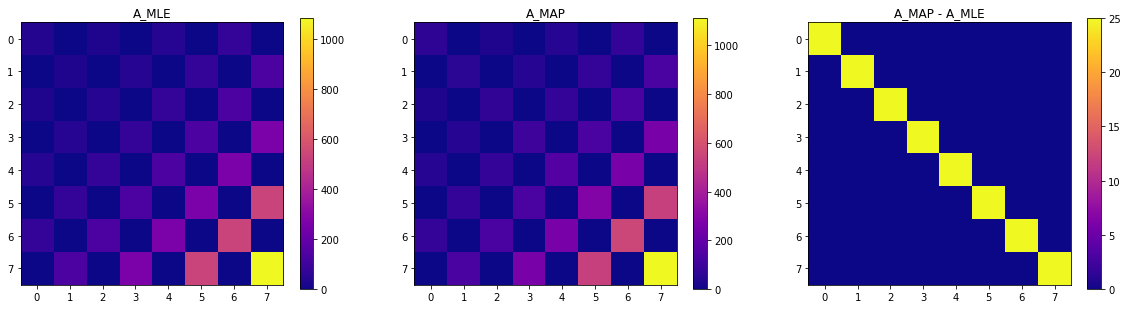

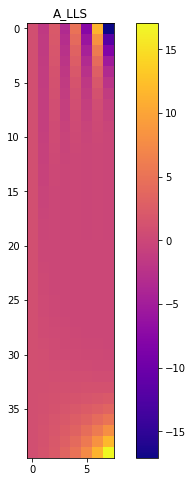

In [20]:
A_MLE, b_MLE = PolRegMLE(p, mu, x, y)
A_MAP, b_MAP = PolRegMAP(p, mu, sigma, alpha, beta ,x, y)
A_LLS, b_LLS = PolRegLLS(p, n, x, y)


print('Condition number of A_MLE: {:.5f}'.format(cond(A_MLE)))
print('Condition number of A_MAP: {:.5f}'.format(cond(A_MAP)))
print('Condition number of A_LLS: {:.5f}'.format(cond(A_LLS)))
print('Condition number of A_LLS.dot(A_LLS.T): {:.5f}'.format(cond(A_LLS.dot(A_LLS.T))))


plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(A_MLE, origin='upper', cmap='plasma')
plt.colorbar()
plt.axis('on')
plt.title('A_MLE')
plt.subplot(132)
plt.imshow(A_MAP, origin='upper', cmap='plasma')
plt.colorbar()
plt.axis('on')
plt.title('A_MAP')
plt.subplot(133)
plt.imshow(A_MAP-A_MLE, origin='upper', cmap='plasma')
plt.colorbar()
plt.axis('on')
plt.title('A_MAP - A_MLE')
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(A_LLS, origin='upper', cmap='plasma')
plt.colorbar()
plt.axis('on')
plt.title('A_LLS')
plt.show()

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell to benchmark the robustness of your MLE, MAP and LLS solvers. 
</div>

<div class="alert alert-success" role="alert">
    MAP should be more robust than MLE and LLS since it is given the exact prior. 
    Also, MLE and LLS should look quite similar.
</div>

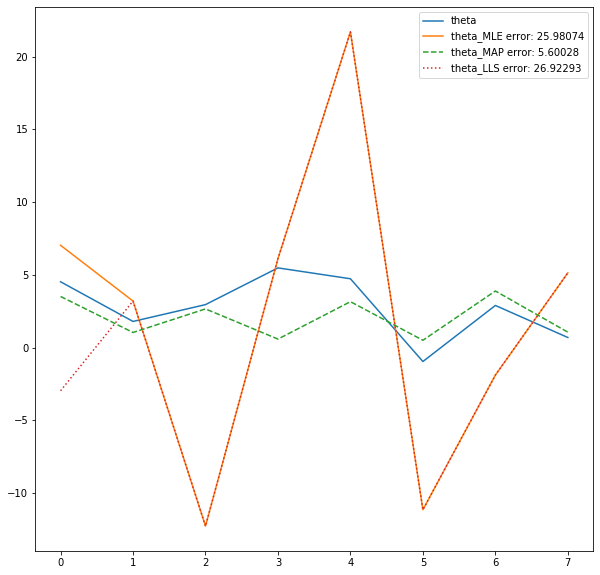

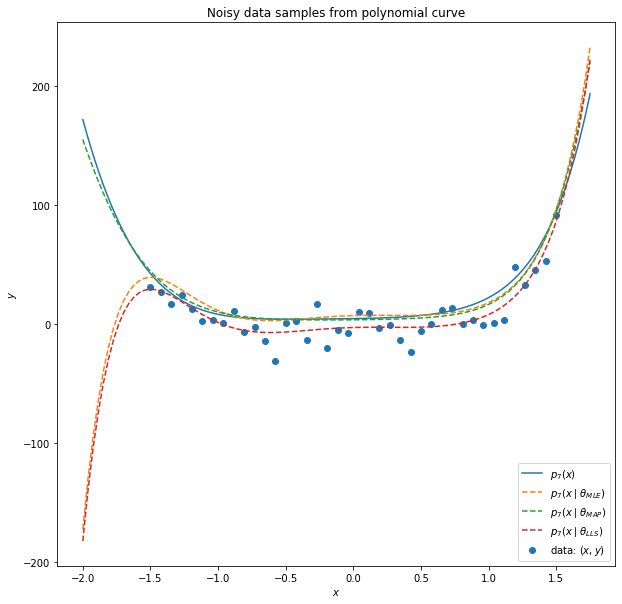

In [21]:
theta_MLE = solve(A_MLE,b_MLE)
theta_MAP = solve(A_MAP,b_MAP)
theta_LLS = lstsq(A_LLS,b_LLS, rcond=None)[0]

plt.figure(figsize=(10,10))
plt.plot(theta, label='theta')
plt.plot(theta_MLE, '-', label='theta_MLE error: {:.5f}'.format(norm(theta_MLE-theta,2)))
plt.plot(theta_MAP, '--', label='theta_MAP error: {:.5f}'.format(norm(theta_MAP-theta,2)))
plt.plot(theta_LLS, ':', label='theta_LLS error: {:.5f}'.format(norm(theta_LLS-theta,2)))
plt.legend()
plt.show()

z = linspace(-2., 1.75, 100)  # Independent variable x
plt.figure(figsize=(10,10))
plt.scatter(x, y, label='data: $(x, y)$')
plt.plot(z, poly(z), label='$p_{{ {0} }}(x)$'.format(m))
plt.plot(z, polyval(theta_MLE[::-1], z), '--',label='$p_{{ {0} }} (x \mid \\theta_{{MLE}})$'.format(m))
plt.plot(z, polyval(theta_MAP[::-1], z), '--',label='$p_{{ {0} }} (x \mid \\theta_{{MAP}})$'.format(m))
plt.plot(z, polyval(theta_LLS[::-1], z), '--',label='$p_{{ {0} }} (x \mid \\theta_{{LLS}})$'.format(m))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Noisy data samples from polynomial curve')
plt.legend()
plt.show()



# Mixture models with Expectation-Maximization [60%]

We will implement and use the *expectation-maximization* (EM) algorithm to fit a *Gaussian mixture model* (GMM) to complex, multi-modal data. Afterwards, we will apply GMMs to an image *color segmentation* problem.

![Fitting a GMM to random, multi-modal data using the EM algorithm.](./gaussian_mixture.png) 


<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell in the Jupyter Notebook to include the required modules for this section.
</div>

In [22]:
%matplotlib inline

import math
import random
from os import path, mkdir

from PIL import Image, ImageFilter
from numpy import histogram, searchsorted, linspace, float32, int32, array, identity, zeros, zeros_like
from numpy import full, log, sum, mean, dot, outer, mod, arange, amin, amax, maximum, argmax, log, sqrt, degrees,arctan2
from numpy.linalg import norm, svd
from numpy.random import randint, choice, uniform, seed
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.patches import Ellipse

<div class="alert alert-warning" role="alert">
     Be mindful of the performance of your code. Specifically, while it may be more natural to use (nested) loops to iteratively perform operations on vectorized data, you should instead rely on <code>numpy</code>'s built-in functions as much as possible -- this may require some digging through the documentation. Without this, Python will not exploit vectorized opcode-level optimizations, and will run much slower. Moreover, we will impose a (sufficiently lenient) time limit on the execution of some cells in your algorithm.
</div>

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell in the Jupyter Notebook to define the  <code>%%exit_after</code> function decorator. This decorator enforces our time-based cell execution limit -- you can safely ignore this code, after you run it.
</div>

In [23]:
from __future__ import print_function
import sys
import threading
from time import sleep
try:
    import thread
except ImportError:
    import _thread as thread
    
try:
    range, _print = xrange, print
    def print(*args, **kwargs): 
        flush = kwargs.pop('flush', False)
        _print(*args, **kwargs)
        if flush:
            kwargs.get('file', sys.stdout).flush()            
except NameError:
    pass

def quit_function(fn_name):
    # print to stderr, unbuffered in Python 2.
    print('{0} took too long'.format(fn_name), file=sys.stderr)
    sys.stderr.flush() # Python 3 stderr is likely buffered.
    thread.interrupt_main() # raises KeyboardInterrupt
    
def exit_after(s):
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer


## Background

Consider many $d$-dimensional data samples $\bfx_i$ drawn from a *mixture model* parameterized by $\bstheta$.

Our examples use a *mixture of multivariate normal distributions* $\gaussian( x | \bsmu, \bsSigma)$ (i.e., high-dimensional, anisotropic Gaussians), with $K$ *mixture components*, and so our $\bstheta=\{\bsmu_0,\ldots,\bsmu_{K-1},\bsSigma_0,\ldots,\bsSigma_{K-1},\pi_0,\ldots,\pi_{K-1}\}$, where 

* each of the $K$ $d$-dimensional Gaussians are parameterized by a $d$-dimensional mean vector $\bsmu_i$, a $d\times d$ covariance matrix $\bsSigma_i$ (see below), and
* the normalized _mixture proportions_ $\pi_c$ weight the amount of each of the $K$ components in the mixture, with $\sum_{c=0}^{K-1} \pi_c = 1$.

We use the standard definition of a $d$-dimensional multivariate normal distribution, with density:
$$
\gaussian(\bfx | \bsmu, \bsSigma) = \frac{1}{(2\pi)^{d/2}|\bsSigma|^{1/2}}\exp\left[-\frac{1}{2}(\bfx-\bsmu)^\intercal\bsSigma^{-1}(\bfx-\bsmu)\right]~,
$$
and so the marginal distribution of $\bfx_i$ is:
$$
P(\bfx_i | \bstheta) = \sum\limits_{c=0}^{K-1}\pi_c \gaussian(\bfx_i | \bsmu_c,\bsSigma_c)~.
$$

As such, the joint probability of $n$ i.i.d. data samples $\widehat{\bfx} = \{\bfx_0,\ldots,\bfx_{n-1}\}$ is 
$$
P(\widehat{\bfx}| \bstheta) = \prod\limits_{i=0}^{n-1}\sum\limits_{c=0}^{K-1}\pi_c \gaussian(\bfx_i | \bsmu_c,\bsSigma_c)~.
$$

And so, given the samples $\widehat{\bfx}$ and knowing only the number of mixture components $K$, our goal is to estimate the mixture's parameters $\bstheta$ that best match the data: the means $\bsmu_c$ (i.e., centers), covariances $\bsSigma_c$ (i.e., anisotropic shapes), and weights $\pi_c$ of the mixture components.

<!--
!!! tip: Let's use MLE!
    It may seem natural at this point to derive an MLE for $\bstheta$, however the derivative of the log-likelihood does not allow us to isolate a solution to the parameters, due to a non-linear term.

In our context, we have $\bstheta=\{\mu_0,\ldots,\mu_{K-1},\Sigma_0,\ldots,\Sigma_{K-1},\pi_0,\ldots,\pi_{K-1}\}$ and  $x_i|z_i=c, \bstheta \sim \gaussian(\mu_c,\Sigma_c)$ 
-->

### From MLE to Expectation-Maximization

A natural step is to derive an MLE for $\bstheta$. The likelihood function is simply the joint probability 
$P(\widehat{\bfx} | \bstheta)$, and so the log-likelihood is
$$
\log P(\widehat{\bfx} | \bstheta) = \sum\limits_{i=0}^{n-1}\log\left(\sum\limits_{c=0}^{K-1} \pi_c\gaussian(\bfx_i | \bsmu_c,\bsSigma_c)\right)~.
$$

We immediately run into difficulties when differentiating with respect to, say, $\bsmu_k$:
$$
\pder{\bsmu_j}\log P(\widehat{\bfx} | \bstheta) = \sum\limits_{i=0}^{n-1}\left(\frac{\pi_j \gaussian(\bfx_i | \bsmu_j,\bsSigma_j)}{ \sum\limits_{c=1}^{K}\pi_c \gaussian(\bfx_i | \bsmu_c,\bsSigma_c)}\right) (\bfx_i - \bsmu_j)\bsSigma_j^{-1} = 0~,
$$
as we are unable to isolate $\bsmu_k$. There is a non linearity induced by the $\left(\pi_k \gaussian(\bfx_i | \bsmu_k,\bsSigma_k)\right)\Big/\left( \sum\limits_{c=1}^{K}\pi_c \gaussian(\bfx_i | \bsmu_c,\bsSigma_c)\right)$ term. We face similar problems when differentiating with respect to other parameters in $\bstheta$.


To sidestep this issue, we will introduce the concept of a _latent label_ $z_i \in \{1, \ldots, K\}$ of each data sample $\bfx_i$.

This latent label corresponds to the ground truth association of each data sample to its corresponding mixture component, and so $\pi_c = P(z_i = c|\bstheta)$.

By the *law of total probability*, the marginal conditional probability distribution of $\bfx_i$ given $\bstheta$ can be re-written as
$$
P(\bfx_i | \bstheta) = \sum\limits_{c=0}^{K-1} \underbrace{P(z_i=c | \bstheta)}_{\pi_c} \, \underbrace{P(\bfx_i | z_i=c, \bstheta)}_{\gaussian(\bfx_i | \bsmu_c,\bsSigma_c)}~.
$$

Intuitively, knowing the latent variables $z_i$ should help us in computing the MLE. To do so, we first compute the posterior $P(z_i = k | \bfx_i, \bstheta)$ using Bayes' law:
$$
r_{i,j} := P(z_i = j | \bfx_i, \bstheta) =  \frac{P(\bfx_i | z_i = j, \bstheta) P(z_i = c|\bstheta)}{ P(\bfx_i | \bstheta)} =  \frac{P(z_i = j|\bstheta) P(\bfx_i | z_i = j, \bstheta) }{ P(\bfx_i | \bstheta)}
 = \frac{\pi_j \gaussian(\bfx_i | \bsmu_j,\bsSigma_j)}{ \sum\limits_{c=0}^{K-1}\pi_{c} \gaussian(\bfx_i | \bsmu_{c},\bsSigma_{c})}~.
$$

We can now rewrite the partial derivative of the log-likelihood with respect to $\bsmu_k$ as:
$$
\pder{\bsmu_j}\log P(\widehat{\bfx} | \bstheta) =\sum\limits_{i=0}^{n-1} r_{i,j} (\bfx_i - \bsmu_j)\bsSigma_j^{-1} = 0~.
$$

Even though $r_{i,j}$ depends on $\bsmu_j$, we can define an __iterative process__ that _assumes_ we _have_ an approximate value of $r_{i,j}$ and solving for $\bsmu_j$ as:
$$
\bsmu_j =\frac{1}{\omega_j}\sum\limits_{i=0}^{n-1}r_{i,j} \, \bfx_i
$$

where $\omega_j = \sum_{i=0}^{n-1} r_{i,j}$ can be interpreted as the effective number of data samples assigned to the mixture component $j$. We can similarly obtain expressions for the other parameters as:
$$
\bsSigma_j = \frac{1}{\omega_j}\sum\limits_{i=0}^{n-1}r_{i,j} (\bfx_i-\bsmu_j)^\intercal(\bfx_i-\bsmu_j)  \quad\text{and} \quad \pi_j = \frac{\omega_j}{n}~.
$$ 

After computing these (updated) values for the $\bsmu_j$, $\bsSigma_j$ and $\pi_j$, we can recompute new estimates for $r_{i,j}$ from the expression we derived using Bayes' theorem. We repeat this process until "convergence".


### Formalizing the EM algorithm

To summarize:
* if we knew the parameters $\bstheta$, we could compute the posterior probabilities $r_{i,j}$, and
* if we knew the posteriors $r_{i,j}$, we could compute the parameters $\bstheta$.

The EM algorithm proceeds as follows:
0. **Initialize** the parameters $\bstheta$ and evaluate the log-likelihood $\log P(\widehat{\bfx} | \bstheta)$ with these parameters,
1. **E-step**: evaluate the posterior probabilities $r_{i,j}$ using the current values of the parameters $\bstheta$,
2. **M-step**: estimate new parameters $\bstheta$ with the current values of $r_{i,j}$,
3. **Evaluate** the log-likelihood $\log P(\widehat{\bfx} | \bstheta)$ with the new parameter estimates. If the log-likelihood has changed by less than some small value, terminate; otherwise, return to step 1 and repeat.

<div class="alert alert-success" role="alert">
    EM is sensitive to the initial values of the parameters, so special care must be taken in the first step. 
    Given "valid" initial values, however, the EM algorithm guarantees that the log-likelihood increases after every iteration. 
</div>
<div class="alert alert-success" role="alert">
    During EM iterations with GMMs, covariance matrices may become singular. To circumvent this problem, we 
    will add diagonal offsets to regularize these matrices. Note, however, that using too large a regularization can lead to the algorithm failing to converge (and, e.g., possibly **reducing** the log-likelihood estimate from one iteration to the next.)
</div>

We provide a basic class structure to encapsulate GMM parameters and some utility methods. 

<div class="alert alert-warning" role="alert">
    When implementing the subsequent functions, you should only require explicit loops <b>over the mixture component</b>. All other vector operations are realizable using <code>numpy</code> vectorized 
    functions such as <code>sum( , axis=) </code>,  <code>dot( , axis=)</code>,  <code>argmax( , axis=)</code> and the component-wise array operators  <code>+</code>,  <code>-</code> ,  <code>*</code> and  <code>/</code>. 
    We similarly provide access to the <code>multivariate_normal</code> class from the <code>scipy.stats</code> library, whose method <code>pdf()</code> is both vectorized and implements the Gaussian density.
</div>

<div class="alert alert-info" role="alert">
    <b>Read</b> and <b>Run</b> the following cell to initialize your GMM class.
</div>

In [27]:
class GMM:
    """ Class containing Gaussian mixture model data and utility methods"""

    def __init__(self, X, n_components=10, reg_covar=1e-2, tol=1e-4, max_iter = 100, verbose = True, do_plot = False, mu_init=None):
        """ Constructor of the GMM class
            
        Parameters: 
        X (np.array((n_samples, n_dim))): array containing the n_samples n_dim-dimensional samples
        n_components (int): number of component of our GMM
        reg_covar (float): regularization value to add to the diagonal of the covariances matrices
        tol (float): log-likelihood tolerance, at wich point we will stop the algorithm
        max_iter (int): maximum number of iteration
        mu_init (np.array((n_components, n_dim))): array containing initial mean of each Gaussian. if None, we will sample them from X.
        verbose (bool): True to print outputs
        do_plot (bool): True to print GMM at each iterations

        """

        self.X = X.astype(float32)
        self.n_components = n_components
        self.reg_covar = reg_covar**2
        self.tol = tol
        self.max_iter = max_iter
        self.verbose = verbose
        self.do_plot = do_plot
        self.reg_covar = reg_covar**2

        self.init_covar = 0.5*(amax(X)- amin(X))/self.n_components          # initial covariance size
        self.n_samples, self.n_dim = self.X.shape                           # number of sample, dimension of the data
        self.reg_cov = self.reg_covar*identity(self.n_dim, dtype=float32)   # regularization matrix
        self.init_cov = self.init_covar*identity(self.n_dim, dtype=float32) # initial covariance matrix
        
        """ Set the initial mu, covariance and pi values """
        # Numpy array containing the mean of each gaussian
        # This is a (n_components x n_dim) matrix
        if mu_init is None:
            # Initialize mean vector as random element of X
            self.mu = self.X[choice(range(0,self.n_samples), self.n_components, replace=False),:]
        else:
            try:
                assert( mu_init.shape[0] == self.n_components and mu_init.shape[1] == self.n_dim )
            except:
                raise Exception('Can\'t plot if not 2D')
            # Initialize mean vector from the provided means mu_init
            self.mu = mu_init 
        
        # Numpy array containing the covariance matrix of each Gaussian
        # This is a (n_components x n_dim x n_dim) tensor
        # Initialize covariances matrices as diagonal matrix (isotropic Gaussian)
        self.cov = zeros((self.n_components, self.n_dim, self.n_dim), dtype=float32)
        for c in range(self.n_components):
            self.cov[c,:,:] = self.init_cov

        # List containing the n_components multivariate gaussian
        # Each gaussian have a method .pdf(X) that act on an array X and
        # return an array of the same size containing the pdf's at each of X values
        self.gauss = []
        for c in range(self.n_components):
            self.gauss.append(multivariate_normal(mean=self.mu[c,:],cov=self.cov[c,:,:]))    
        
        # Numpy array containing the probability of selecting a specific Gaussian
        # This is a (n_components,) vector
        # Uniform chance of selecting each Gaussian at the start, e.g. 1/K
        self.pi = full(self.n_components, 1./self.n_components, dtype=float32)
        
        # Numpy array containing the weight of each Gaussian
        # This is a (n_components,) vector
        # Initialize to 0
        self.weight = zeros(self.n_components, dtype=float32)
        
        # Numpy array containing probability of sample X_i being from Gaussian N_c
        # This is a (n_samples, n_components) Matrix
        # Initialize to 0
        self.r_ik = zeros((self.n_samples, self.n_components), dtype=float32)
        
        # Numpy array containing normalization factors of r_ik
        # This is a (n_samples) vector
        # Initialize to 0
        self.r_i = zeros(self.n_samples)
        
        # Numpy array containing the label of the Gaussian that has maximum probability of having generated the sample x_i
        # This is a (n_samples) Vector of int
        # Initialize to 0
        self.Z = zeros(self.n_samples, dtype=int32)
        
        # List containing the log likelihood of each iteration
        # We won't know its length before the end of the algorithm
        self.log_likelihoods = [] 

    def draw_ellipse(self, k, **kwargs):
        """Draw an ellipse corresponding to the k-th Gaussian"""
        try:
            assert(self.n_dim == 2)
        except:
            raise Exception('Can\'t plot if not 2D')
            
        ax = plt.gca()

        # Convert covariance to principal axes
        U, s, Vt = svd(self.cov[k,:,:])
        angle = degrees(arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * sqrt(s)

        # Draw the Ellipse
        for nsig in range(1, 4):
            ax.add_patch(Ellipse(self.mu[k,:], nsig * width, nsig * height, angle, **kwargs))
        

    def plotGMM(self, samples=None, labels=None, ellipse=True):
        try:
            assert(self.n_dim == 2)
        except:
            raise Exception('Can\'t plot if not 2D')
            
        plt.figure(figsize=(10,10))
        
        colors = cm.viridis(linspace(0, 1, self.n_components))
        if samples is None or labels is None:
            plt.scatter(self.X[:, 0], self.X[:, 1], c=colors[self.Z,:], s=10)
        else:
            try:
                assert(self.n_dim == samples.shape[1] and samples.shape[0]  == labels.shape[0])
            except:
                raise Exception('Can\'t plot if not 2D')
            plt.scatter(samples[:, 0], samples[:, 1], c=colors[labels,:], s=10)
        plt.axis('equal')
        
        w_factor = 0.2 / self.weight.max()
        if ellipse:
            for k in range(self.n_components):
                self.draw_ellipse(k, alpha = w_factor*self.weight[k], color=colors[k,:3])
                plt.scatter(self.mu[k,0], self.mu[k,1], marker='*', s = 100)

        plt.show()


    def plotLogLikelihood(self):
        """Plot log-likelihood of our model """
        
        plt.figure(figsize=(10, 10))
        plt.plot(self.log_likelihoods)
        plt.title('Log-Likelihood')
        plt.show()

## EM Implementation 

<u style="font-size:16pt;">Compute normalization of the mixture for all the samples</u>

Compute the mixture normalization factor, given the current parameters $\bstheta$, for all the data samples using **only one for loop**
over the mixture components: 
$$
r_i :=\sum\limits_{c=0}^{K-1}\pi_c \gaussian(\bfx_i | \bsmu_c,\bsSigma_c)~.
$$

You will use the result of this function in the expectation step and log-likelihood computation.

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Complete</b> the implementation of the normalization function in the cell below.
</div>

In [28]:
def normalization(gmm):     
    """compute mixture normalization factor for all data samples
        
    Compute the entries of r_i, i.e., the mixture normalization factor at each sample x_i.

    Parameters: 
    gmm (Class GMM): our GMM instance

    Returns: 
    Nothing, but it should modify gmm.r_i

    """

    # You should only loop over the mixture components (use list comprehension if you can)
    # Tip 1: use the vectorized pdf() method of the multivariate_normal class
    # Tip 2: use sum(..., axis=)
    
    # YOUR CODE HERE
    print("n, d: ", gmm.X.shape)
    k = gmm.pi.shape[0]
    print("mu", gmm.mu.shape)
    print("cov_shape", gmm.cov.shape)
    gmm.r_ik = array([array([gmm.pi[j]*multivariate_normal.pdf(gmm.X[i], mean=gmm.mu[j, :], cov=gmm.cov[j, :, :]) 
                       for j in range(k)]) for i in range(n)])
    print("r_ik shape", gmm.r_ik.shape)
    gmm.r_i = sum(gmm.r_ik, axis=1)
    print("Normalization ok")
    #raise NotImplementedError()

<u style="font-size:16pt;">Expectation step</u>

Using the values of $r_{i}$, you have to compute the posterior density using **only one for loop** over the mixture components:
$$
r_{i,j} = \frac{\pi_j \gaussian(\bfx_i | \bsmu_j,\bsSigma_j)}{r_i}
$$

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Complete</b> the implementation of expectation function in the cell below.
</div>

In [29]:
def expectation(gmm):           
    """ Expectation step

    Compute the entries of r_ij, i.e., the probability of sample i belonging to Gaussian j.

    Parameters: 
    gmm (Class GMM): our GMM instance

    Returns: 
    Nothing, but it should modify gmm.r_ij

    """

    # You can loop over the mixture components ONLY
    # and assume that you already know r_i 
    
    # YOUR CODE HERE
    n, k = gmm.r_ik.shape
    gmm.r_ik = array([array([gmm.r_ik[i, j]/gmm.r_i[i] for j in range(k)]) for i in range(n)])
    print(gmm.r_ik.shape, "expectation step")
    # raise NotImplementedError()

<u style="font-size:16pt;">Maximization step</u>

Using the values of $r_{i,j}$ you have to compute the following quantities using **only one for loop** over the mixture components:
$$
z_{i} = \argmax{j} r_{i,j} \quad\quad \omega_j = \sum\limits_{i=0}^{n-1}r_{i,j} \quad\quad \pi_j = \frac{\omega_j}{n} \quad \quad
\bsmu_j = \frac{1}{\omega_j}\sum\limits_{i=0}^{n-1}r_{i,j}\,\bfx_i
$$
$$
\bsSigma_j = \frac{1}{\omega_j}\sum\limits_{i=0}^{n-1}r_{i,j}(\bfx_i-\bsmu_j)^\intercal(\bfx_i-\bsmu_j) + \bsSigma_{\text{Reg}}
$$

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Complete</b> the implementation of maximization function in the cell below.
</div>
<div class="alert alert-success" role="alert">
    Don't forget to regularize the covariance matrices.
</div>

In [30]:
def maximization(gmm):                   
    """Maximization step
    
    Compute the parameters (Z, weight, pi, mu, cov, gauss) updated values using r_ik
    
    Parameters: 
    gmm (Class GMM): our GMM instance that contains our data, parameters, etc..
    
    Returns: 
    Nothing, but it should modify gmm.(labels, weight, pi, mu, cov, gauss)
    
    """
    
    # You can loop over the mixture components ONLY
    # and assume that you already know r_ik 
    # Tip 1: you should use argmax, sum and dot with the appropriate axis.
    # Tip 2: To access and use a column or r_ik, you should use gmm.r_ik[:,[k]] 
    #       to get (gmm.n_samples,1) as shape instead of ((gmm.n_samples,)
    # Tip 3: gmm.reg_cov is small matrix that we add to the covariance to
    #        to prevent the covariances from being singular
    
    # YOUR CODE HERE
    n = gmm.X.shape[0]
    k = gmm.mu[0]
    d = gmm.X.shape[1]
    gmm.Z = argmax(gmm.r_ik, axis=1)
    gmm.pi = (1.0/n)*sum(gmm.r_ik, axis=0)
    gmm.mu = dot(1.0/gmm.pi, gmm.r_ik.T*gmm.X)
    for i in range(k):
        x = gmm.X[:, i] - gmm.mu[i]
        y = outer(x.T, x)
        print("r_ik.shape, x.T*x", gmm.r_ik.shape, y.shape)
        gmm.cov[:, i] = gmm.reg_cov[:, i] + dot(1.0/gmm.pi, sum(gmm.r_ik*y))
    print(gmm.cov.shape, "maximization step")
    #raise NotImplementedError()

<u style="font-size:16pt;">Computing the log-likelihood</u>

Now, we can compute the log-likelihood estimate using the current values of $r_i$, relying only on built-in <code>numpy</code> routines:
$$
\log P(\widehat{\bfx} | \bstheta) = \sum\limits_{i=0}^{n-1}\log\left(r_i\right)
$$

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Complete</b> the implementation of log-likelihood function in the cell below.
</div>

In [31]:
def logLikelihood(gmm):                        
    """Log likelihood computation

    Compute the current log likelihood of the model.

    Parameters: 
    gmm (Class GMM): our GMM instance

    Returns: 
    Nothing, but it should modify gmm.log_likelihoods

    """

    # You need to append to gmm.log_likelihoods
    # and assume that you already know r_i 
    
    # YOUR CODE HERE
    gmm.log_likelihoods.append(sum(log(gmm.r_i)))
    
    #raise NotImplementedError()
    
    if len(gmm.log_likelihoods) > 1:
        try:
            assert(gmm.log_likelihoods[-1] >= gmm.log_likelihoods[-2])
        except:
            raise Warning('The log likelihood is not supposed to increase!')

### Predicting mixture membership of new/unseen data samples 

You may face problems where it is prohibitively slow to perform GMM parameter estimation on all of your data (e.g., the color segmentation problem later on in the assignment.)

Here, a common strategy is to use only a subset of data samples to estimate the GMM parameters. Once these model parameters are estimated, however, you will need to predict the mixture component labels for all of the unseen samples from your data distribution. To do so, you first compute the posterior density given all the new samples and then, for each sample, return the component with the highest posterior probability.


<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Complete</b> the implementation of predict function in the cell below.
</div>
<div class="alert alert-success" role="alert">
    This function should resemble your normalization and expectation routines.
</div>

In [32]:
def predict(gmm, Y):     
    """ Predict the labels of new data points Y

    Compute the labels of every new sample. These labels correspond to the 
    mixture component with the highest probability of having generated the sample.

    Parameters: 
    gmm (Class GMM): our GMM instance 
    Y (np.array(( n_test_samples ,gmm.n_dim))): new data points that we wish to label.

    Returns: 
    labels (np.array(n_test_samples): Array containing the labels associated to each of Y's samples
    """
    
    n_test_samples = Y.shape[0]
    labels = zeros(n_test_samples, dtype=int32) 
    r_jk = zeros((n_test_samples, gmm.n_components), dtype=float32) 
    
    # You can loop over the mixture components
    # Tip: This funtion should look a loooot like normalization() and expectation()...
    
    # YOUR CODE HERE
    gmm = GMM(Y)
    
    """compute mixture normalization for all the samples"""
    normalization(gmm)
    """Log likelihood computation"""
    logLikelihood(gmm)
          
    for n in range(1,gmm.max_iter):               

        """Expectation step"""
        expectation(gmm)

        """Maximization step"""
        maximization(gmm)
        
        """compute the new mixture normalization for all the samples"""
        normalization(gmm)
        
        """Log likelihood computation"""
        logLikelihood(gmm)

        error = abs(gmm.log_likelihoods[-2] / gmm.log_likelihoods[-1])
        if (abs(1-error) < gmm.tol):
            expectation(gmm)
            labels = gmm.Z
            return labels

    print("Convergence not obtained!")
    
    #raise NotImplementedError()
    
    


### End-to-end EM: putting the pieces together

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Run</b> the following cell to setup the entire the EM algorithm.
</div>

In [33]:
@exit_after(90)
def run(gmm):
    """Run the expectation-maximization algorithm on a GMM
    
    Fit a GMM to our data using the expectation-maximization algorithm.
    
    Parameters: 
    gmm (Class GMM): our GMM instance
    
    Returns: 
    Nothing, but it should modify gmm using the previously defined functions
    
    """
    
    """E-M iterations, will break depending on log likelihood"""
    """Log likelihood computation"""
    if gmm.verbose:
        print('Iteration: {:4d}'.format(0), flush=True)
    """compute mixture normalization for all the samples"""
    normalization(gmm)
    """Log likelihood computation"""
    logLikelihood(gmm)
          
    for n in range(1,gmm.max_iter):               

        """Expectation step"""
        expectation(gmm)

        """Maximization step"""
        maximization(gmm)
        
        """compute the new mixture normalization for all the samples"""
        normalization(gmm)
        
        """Log likelihood computation"""
        logLikelihood(gmm)

        error = abs(gmm.log_likelihoods[-2] / gmm.log_likelihoods[-1])
        
        if gmm.verbose:
            print('Iteration: {:4d} - log likelihood ratio: {:1.6f}'.format(n, error), flush=True)
        
        if gmm.do_plot:
            gmm.plotGMM(ellipse=True)
        
        if (abs(1-error) < gmm.tol):
            expectation(gmm)
            if gmm.verbose:
                print('Success! You won the race!', flush=True)
            return
            
    if gmm.verbose:
        print('Uh oh... you ran out of iterations before converging...', flush=True)

<div class="alert alert-success" role="alert">
    You can use the following cell to experiment with your EM algorithm implementation.
</div>

In [43]:
seed(0)

n_component_test = 4
n_test_1 = 500
mean_test_1 = array([0.25, 0.25])
cov_test_1 = 0.0002*array([[75, -70], [-70, 75]])
gauss_test_1 = multivariate_normal(mean=mean_test_1,cov=cov_test_1)

n_test_2 = 500
mean_test_2 = array([0.75, 0.75])
cov_test_2 = 0.0002*array([[1, 0], [0, 75]])
gauss_test_2 = multivariate_normal(mean=mean_test_2,cov=cov_test_2)

n_test_3 = 500
mean_test_3 = array([0.25, 0.75])
cov_test_3 = 0.02*array([[1, 0], [0, 1]])
gauss_test_3 = multivariate_normal(mean=mean_test_3,cov=cov_test_3)

n_test_4 = 500
mean_test_4 = array([0.75, 0.25])
cov_test_4 = 0.01*array([[1, 0], [0, 1]])
gauss_test_4 = multivariate_normal(mean=mean_test_4,cov=cov_test_4)

training_test = [gauss_test_1.rvs() for i in range(n_test_1)]
training_test.extend([gauss_test_2.rvs() for i in range(n_test_2)])
training_test.extend([gauss_test_3.rvs() for i in range(n_test_3)])
training_test.extend([gauss_test_4.rvs() for i in range(n_test_4)])
training_test = array(training_test)

gmm_test  = GMM(training_test, n_component_test, reg_covar=1e-3, tol=1e-6, max_iter=100, verbose = True, do_plot = True)
run(gmm_test)
gmm_test.plotLogLikelihood()

print("Labels prediction on unseen samples")
n_predict = 500
samples_test = [array([gauss_test_1.rvs() for i in range(n_predict)])]
samples_test.append([gauss_test_2.rvs() for i in range(n_predict)])
samples_test.append([gauss_test_3.rvs() for i in range(n_predict)])
samples_test.append([gauss_test_4.rvs() for i in range(n_predict)])
samples_test = array(samples_test)

labels_predict_test = predict(gmm_test, samples_test)
gmm_test.plotGMM(samples=samples_test , labels=labels_predict_test, ellipse=True)

Iteration:    0
n, d:  (2000, 2)
mu (4, 2)
cov_shape (4, 2, 2)
r_ik shape (40, 4)
Normalization ok
(40, 4) expectation step


ValueError: operands could not be broadcast together with shapes (4,40) (2000,2) 

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Run</b> the following cell to validate your the EM algorithm implementation.
</div>

In [35]:
tresh = 0.2

n_test = 3000
n_component_test = 2

pi_test_1 = 0.7
n_test_1 = int(pi_test_1*n_test)
mean_test_1 = array([0,1])
cov_test_1 = 0.01*array([[100, 0], [0, 1]])
gauss_test_1 = multivariate_normal(mean=mean_test_1,cov=cov_test_1)

pi_test_2 = 0.3
n_test_2 = int(pi_test_2*n_test)
mean_test_2 = array([0, -1])
cov_test_2 = 0.01*array([[100, 0], [0, 1]])
gauss_test_2 = multivariate_normal(mean=mean_test_2,cov=cov_test_2)

training_test = [gauss_test_1.rvs() for i in range(n_test_1)]
training_test.extend([gauss_test_2.rvs() for i in range(n_test_2)])
training_test = array(training_test)
gmm_test  = GMM(training_test, n_component_test, mu_init=array([mean_test_1+[0.2,0], mean_test_2+[-0.2,0]]), reg_covar=1e-2, tol=1e-6, max_iter=1000, verbose = False, do_plot = False)
run(gmm_test)
gmm_test.plotGMM(ellipse=True)
gmm_test.plotLogLikelihood()

try:
    assert((abs(1 - sum(gmm_test.pi)) < 1e-2).all())
    print('Good, pi is normalized!')
except:
    gmm_test.plotGMM(ellipse=True)
    print("sum(gmm_test.pi) : ", sum(gmm_test.pi))
    raise Exception("The sum on pi should be 1...")
    
try:
    assert((norm(gmm_test.pi[0] - pi_test_1) < tresh).all() or (norm(gmm_test.pi[0] - pi_test_2) < tresh).all())
    assert((norm(gmm_test.pi[1] - pi_test_1) < tresh).all() or (norm(gmm_test.pi[1] - pi_test_2) < tresh).all())
    print('Good work on cutting that pie!')
except:
    gmm_test.plotGMM(ellipse=True)
    print("pi_test_1 : ", pi_test_1)
    print("pi_test_2 : ", pi_test_2)
    print("gmm_test.pi : ", gmm_test.pi)
    raise Exception("You ate the wrong pie...")
    
if ((norm(gmm_test.pi[0] - pi_test_1) < 0.1).all()):
    idx_1 = 0
    idx_2 = 1
else:
    idx_1 = 1
    idx_2 = 0
    
try:
    assert((norm(gmm_test.mu[idx_1,:] - mean_test_1) < tresh).all() and (norm(gmm_test.mu[idx_2,:] - mean_test_2) < tresh).all())
    print('That mean seem good enough!')
except:
    gmm_test.plotGMM(ellipse=True)
    print("mean_test_1 : ", mean_test_1)
    print("mean_test_2 : ", mean_test_2)
    print("gmm_test.mu : ", gmm_test.mu)

    raise Exception("That\'s not the right mean...")
    
try:
    assert((norm(gmm_test.cov[idx_1,:] - cov_test_1) < tresh).all() and (norm(gmm_test.cov[idx_2,:] - cov_test_2) < tresh).all())
    print('That\'s a nice looking covariance matrix!')
except:
    gmm_test.plotGMM(ellipse=True)
    print("cov_test_1 : ", cov_test_1)
    print("cov_test_2 : ", cov_test_2)
    print("gmm_test.cov : ", gmm_test.cov)
    raise Exception("Ugh... ugly conditioning...")
  
n_predict = 500
samples_test = [gauss_test_1.rvs() for i in range(n_predict)]
samples_test.extend([gauss_test_2.rvs() for i in range(n_predict)])
samples_test = array(samples_test)
labels_test = [idx_1 for i in range(n_predict)]
labels_test.extend([idx_2 for i in range(n_predict)])

labels_predict_test = predict(gmm_test, samples_test)
gmm_test.plotGMM(samples=samples_test , labels=labels_predict_test, ellipse=True)

try:    
    assert((labels_predict_test == labels_test).all())
    print('Awesome predictions!')
except:
    gmm_test.plotGMM(samples=samples_test,labels=labels_predict_test,ellipse=True)
    raise Exception("Prediction was a no-go :-(")

n, d:  (3000, 2)
mu (2, 2)
cov_shape (2, 2, 2)
r_ik shape (40, 2)
Normalization ok
(40, 2) expectation step


ValueError: operands could not be broadcast together with shapes (2,40) (3000,2) 

## GMM for image color segmentation

We can apply GMMs to an **image segmentation problem**: namely, how to partition an image into several segments (sets of pixels) in order to either simplify and/or modify the image into a form that is more amenable for analysis. 

Specifically, image segmentation assigns a discrete label to each pixel in an image such that pixels with the same label 
share certain characteristics. Our example performs *color image segmentation*, where this characteristic is the RGB value of the pixel.

![Given a source image, you will use a GMM to cluster the color distribution of the image.](color_segmentation.png)


You will fit a GMM to the distribution of colors in an image.

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Run</b> the following cell to check if your image is in the correct folder and to define your training parameters.
</div>
<div class="alert alert-success" role="alert">
    A common technique to improve performance for larger problems is to down sample the image, compute the mixture, and then reassign the labels to the larger image using the <code>predict</code> function.
</div>


In [36]:
n_components = 20     # number of components in your GMM
subsample_factor = 100 # factor used to subsample your image pixels

img_name = 'big_bear' # your image name
img_ext = '.png'      # your image extension

In [37]:
try:
    assert(path.exists(''.join([img_name, img_ext])))
    print('Image located!')
except:
    img_name = 'big_bear' 
    img_ext = '.png'
    raise Warning('This image do not exist in the current working folder')

# Create results directory
resultsDirName = 'results'
try:
    mkdir(resultsDirName)
    print("Directory " , resultsDirName ,  " created ") 
except FileExistsError:
    print("Directory " , resultsDirName ,  " already exists")

Image located!
Directory  results  created 



<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Run</b> the following cell to load and blur the image you wish to segment.
</div>

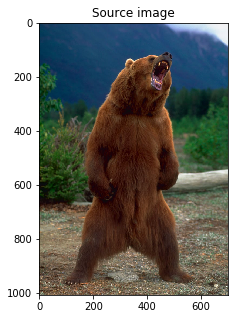

In [38]:
# Loading the image
img_source = Image.open(''.join([img_name, img_ext])).convert('RGB')

# Blurring the image for smoother results
img_blurred = img_source.filter(ImageFilter.BoxBlur(1))              

img_matrix_source = array(img_source)/255.
img_matrix_blurred = array(img_blurred)/255.

n_height, n_width, n_channel = img_matrix_source.shape
n_pixels = n_height * n_width

plt.figure(figsize=(15,5))
plt.imshow(img_matrix_source, origin='upper')
plt.title('Source image')
plt.show()

img_vector_source = img_matrix_source.reshape((n_pixels, n_channel))
img_vector_blurred = img_matrix_blurred.reshape((n_pixels, n_channel))

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Run</b> the following cell to train a GMM on the color spectrum of the image.
</div> 

In [39]:
%%time

# Uniformly sample pixels in the blurred image
samples_idx = choice(n_pixels, int(n_pixels/subsample_factor), replace=False)
training_samples = img_vector_blurred[samples_idx,:]

# Train the GMM
my_gmm_classif = GMM(training_samples, n_components, reg_covar=5e-3, tol=1e-4, max_iter=1000)
run(my_gmm_classif)
my_gmm_classif.plotLogLikelihood()

Iteration:    0
n, d:  (7063, 3)
mu (20, 3)
cov_shape (20, 3, 3)
r_ik shape (40, 20)
Normalization ok
(40, 20) expectation step


ValueError: operands could not be broadcast together with shapes (20,40) (7063,3) 

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Run</b> this cell to visualize the GMM mean distribution over the RGB spectrum histogram of the image.
</div> 

/Users/wasifchowdhury/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


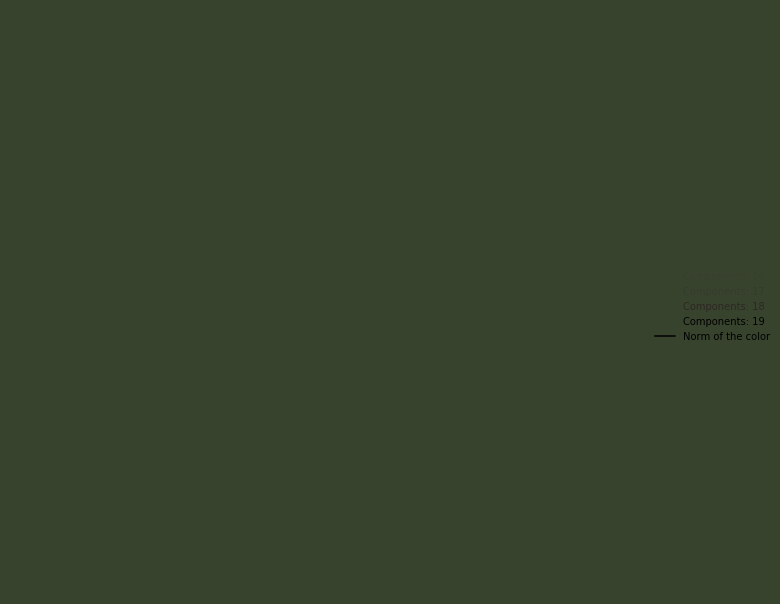

In [40]:
hist, bin_edges = histogram(norm(img_vector_blurred[:,:n_channel]/amax(norm(img_matrix_source, 2, axis = 2)), 2, axis=1), 
                            bins=100)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(10,10))
for c in range(my_gmm_classif.n_components):
    mu_norm = norm(my_gmm_classif.mu[c,:n_channel]/amax(norm(img_matrix_source, 2, axis = 2)), 2)
    mu_color = my_gmm_classif.mu[c,:n_channel]
    mu_relative_weight = (4*(my_gmm_classif.weight[c]+amax(my_gmm_classif.weight))/amax(my_gmm_classif.weight)).astype(int32)
    plt.plot([mu_norm, mu_norm], [0,amax(hist)], alpha=0.65, c=mu_color, linewidth = mu_relative_weight, label='Components: {}'.format(c))

plt.plot(bin_centers, hist , '-k', label='Norm of the color')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.))
plt.ylabel('Number of pixels')
plt.xlabel('Spectrum norm')
plt.title('Histogram of the image spectrum with mixture components mean and weight')
plt.show()

<div class="alert alert-info" role="alert">
    <b style="color:green;">&#9745;</b> <b>Run</b> the cell to predict and plot the labels of every pixel in your image and save the result.
</div>

In [41]:
colors = cm.viridis(linspace(0, 1, my_gmm_classif.n_components))

test_samples = img_vector_blurred
labels = predict(my_gmm_classif,test_samples)

img_matrix_segmented = my_gmm_classif.mu[labels,:].reshape((n_height,n_width,n_channel))
img_matrix_label = colors[labels,:].reshape((n_height,n_width,n_channel+1))

plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(img_matrix_source, origin='upper')
plt.title('Source image')
plt.axis('off')
plt.subplot(132)
plt.imshow(img_matrix_label, interpolation='nearest',cmap = cm.viridis)
plt.title('Label image')
plt.axis('off')
plt.subplot(133)
plt.imshow(img_matrix_segmented, interpolation='nearest')
plt.title('Segmented image')
plt.axis('off')
plt.tight_layout()
plt.savefig(path.join(resultsDirName,''.join([img_name, '_result', img_ext])), bbox_inches='tight',  transparent=True, pad_inches=0)
plt.show()

n, d:  (706300, 3)
mu (10, 3)
cov_shape (10, 3, 3)
r_ik shape (40, 10)
Normalization ok
(40, 10) expectation step


ValueError: operands could not be broadcast together with shapes (10,40) (706300,3) 